In [1]:
# Load scenarios

%matplotlib inline

from collections import Counter, defaultdict
import glob
import gzip
import json
import math
from operator import itemgetter
import os
from pathlib import Path

from IPython.display import display, Markdown
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from pygtrie import StringTrie
import seaborn as sns

JS_CALIBRATION_RESULTS = Path("./js-benchmark-variance")

In [8]:
js_data = defaultdict(list)

for filepath in glob.iglob(os.path.join(JS_CALIBRATION_RESULTS, "*.json")):
    total = 0
    with open(filepath) as f:
        measurements = json.load(f)
    for key, value in measurements.items():
        js_data["scenario"].append(key)
        js_data["timeMs"].append(value["timeMs"])
        total += value["timeMs"]
    js_data["scenario"].append("total")
    js_data["timeMs"].append(total)

js_df = pd.DataFrame(js_data)
js_df.groupby("scenario").describe()

timeMs                              \
                                      count           mean          std   
scenario                                                                  
neptune-mutual-blue-protocol_8db6480   23.0   34656.715010  1149.697509   
openzeppelin-contracts_0a5fba7a        23.0   20428.619362   676.854401   
rocketpool_6a9dbfd8                    23.0   21272.621726   498.032235   
safe-contracts_914d0f8                 23.0    1635.221393    38.607800   
seaport_4f4e7c20                       23.0    7100.016515   200.035804   
synthetix_9a3a109f                     23.0  249884.140528  7191.713979   
total                                  23.0  341486.640528  7978.456398   
uniswap-v3-core_d8b1c63                23.0    6509.305994   210.325924   

                                                                    \
                                                min            25%   
scenario                                                             
neptune-mutual-blue-protocol_8db6480   32436.477349   33778.075723   
openzeppelin-contracts_0a5fba7a        19428.538876   19829.694569   
rocketpool_6a9dbfd8                    20365.509758   20968.660618   
safe-contracts_914d0f8                  1568.692962    1600.423274   
seaport_4f4e7c20                        6836.943660    6919.203593   
synthetix_9a3a109f                    241114.136494  243462.244979   
total                                 330888.553140  334333.975337   
uniswap-v3-core_d8b1c63                 6288.573511    6332.296732   

                                                                    \
                                                50%            75%   
scenario                                                             
neptune-mutual-blue-protocol_8db6480   34620.109161   35398.528329   
openzeppelin-contracts_0a5fba7a        20486.791469   20761.028807   
rocketpool_6a9dbfd8                    21214.410220   21556.757438   
safe-contracts_914d0f8                  1646.712149    1661.228885   
seaport_4f4e7c20                        7135.894720    7237.000893   
synthetix_9a3a109f                    248339.936411  254273.518449   
total                                 340099.010213  347720.885634   
uniswap-v3-core_d8b1c63                 6433.624693    6654.436057   

                                                     
                                                max  
scenario                                             
neptune-mutual-blue-protocol_8db6480   37198.083382  
openzeppelin-contracts_0a5fba7a        21754.840205  
rocketpool_6a9dbfd8                    22472.855396  
safe-contracts_914d0f8                  1696.944801  
seaport_4f4e7c20                        7522.761644  
synthetix_9a3a109f                    265362.745948  
total                                 359486.910097  
uniswap-v3-core_d8b1c63                 6899.403385

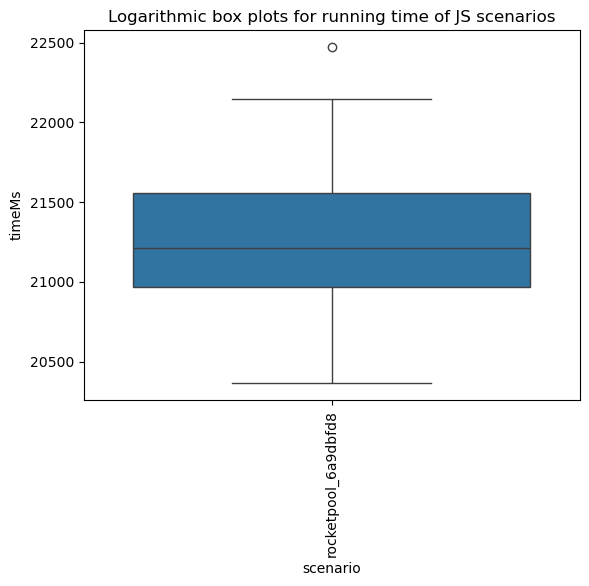

In [14]:
ax = sns.boxplot(x="scenario", y="timeMs", data=js_df)
ax.set(yscale="log")
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title("Logarithmic box plots for running time of JS scenarios")

In [4]:
display(Markdown("Ratio of max/min time for each scenario in JS"))
js_df.groupby("scenario")["timeMs"].max() / js_df.groupby("scenario")["timeMs"].min()

Ratio of max/min time for each scenario in JS

scenario
neptune-mutual-blue-protocol_8db6480    1.146798
openzeppelin-contracts_0a5fba7a         1.119736
rocketpool_6a9dbfd8                     1.103476
safe-contracts_914d0f8                  1.081757
seaport_4f4e7c20                        1.100311
synthetix_9a3a109f                      1.100569
total                                   1.086429
uniswap-v3-core_d8b1c63                 1.097133
Name: timeMs, dtype: float64

In [5]:
display(Markdown("Ratio of 95% percentile over 5% percentile time for each scenario in JS"))
js_df.groupby("scenario")["timeMs"].quantile(0.95) / js_df.groupby("scenario")["timeMs"].quantile(0.05)

Ratio of 95% percentile over 5% percentile time for each scenario in JS

scenario
neptune-mutual-blue-protocol_8db6480    1.095706
openzeppelin-contracts_0a5fba7a         1.105283
rocketpool_6a9dbfd8                     1.069069
safe-contracts_914d0f8                  1.069615
seaport_4f4e7c20                        1.086118
synthetix_9a3a109f                      1.081705
total                                   1.068401
uniswap-v3-core_d8b1c63                 1.094097
Name: timeMs, dtype: float64

In [6]:
js_snapshot_data = defaultdict(list)

for filepath in glob.iglob(os.path.join(JS_CALIBRATION_RESULTS, "*.json")):
    with open(filepath) as f:
        measurements = json.load(f)
    for key, value in measurements.items():
        js_snapshot_data["scenario"].append(key)
        js_snapshot_data["failureCount"].append(len(value["failures"]))

js_snapshot_df = pd.DataFrame(js_snapshot_data)
js_snapshot_df.groupby("scenario").describe()

failureCount                         \
                                            count         mean       std   
scenario                                                                   
neptune-mutual-blue-protocol_8db6480         23.0    571.73913  6.304525   
openzeppelin-contracts_0a5fba7a              23.0   1649.00000  0.000000   
rocketpool_6a9dbfd8                          23.0    390.00000  0.000000   
safe-contracts_914d0f8                       23.0    193.00000  0.000000   
seaport_4f4e7c20                             23.0    305.00000  0.000000   
synthetix_9a3a109f                           23.0  10264.00000  0.000000   
uniswap-v3-core_d8b1c63                      23.0    172.00000  0.000000   

                                                                          \
                                          min      25%      50%      75%   
scenario                                                                   
neptune-mutual-blue-protocol_8db6480    558.0    572.0    575.0    575.0   
openzeppelin-contracts_0a5fba7a        1649.0   1649.0   1649.0   1649.0   
rocketpool_6a9dbfd8                     390.0    390.0    390.0    390.0   
safe-contracts_914d0f8                  193.0    193.0    193.0    193.0   
seaport_4f4e7c20                        305.0    305.0    305.0    305.0   
synthetix_9a3a109f                    10264.0  10264.0  10264.0  10264.0   
uniswap-v3-core_d8b1c63                 172.0    172.0    172.0    172.0   

                                               
                                          max  
scenario                                       
neptune-mutual-blue-protocol_8db6480    575.0  
openzeppelin-contracts_0a5fba7a        1649.0  
rocketpool_6a9dbfd8                     390.0  
safe-contracts_914d0f8                  193.0  
seaport_4f4e7c20                        305.0  
synthetix_9a3a109f                    10264.0  
uniswap-v3-core_d8b1c63                 172.0

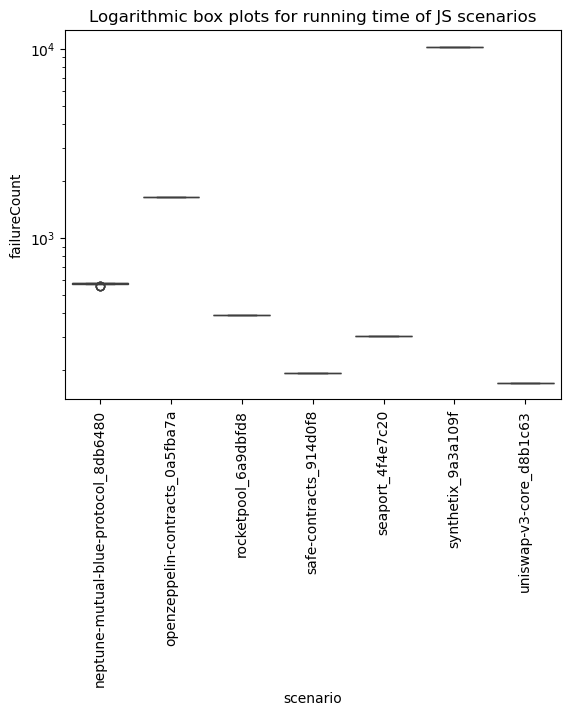

In [7]:
ax = sns.boxplot(x="scenario", y="failureCount", data=js_snapshot_df)
ax.set(yscale="log")
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title("Logarithmic box plots for running time of JS scenarios")